# Depression Classification

---
### Import Necessary Libraries

In [1]:
from wordcloud import WordCloud
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
# from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

---
### Load the data

In [2]:
df = pd.read_csv("/home/jvdboss/workspace/ML_DL/Depression-Detection/Suicide_Detection.csv")

In [19]:
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [20]:
df['class'].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

---
### EDA

In [3]:
train_dataset,test_dataset = train_test_split(df,test_size = 0.2, random_state=42)

In [22]:
train_dataset['class'].value_counts()

suicide        92909
non-suicide    92750
Name: class, dtype: int64

In [23]:
train_dataset['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [24]:
test_dataset['class'].value_counts()

non-suicide    23287
suicide        23128
Name: class, dtype: int64

In [25]:
test_dataset['class'].value_counts().index.values

array(['non-suicide', 'suicide'], dtype=object)

In [26]:
plx.bar(train_dataset, x = train_dataset['class'].value_counts().index.values,
       y = train_dataset['class'].value_counts(), color = ['Suicide','Not Suicide'])

In [4]:
def text_cleaning(text):
    text_len = []
    clean_text = []
    for sentance in text:
        sentance = sentance.lower()
        sentance = nfx.remove_special_characters(sentance)
        sentance = nfx.remove_stopwords(sentance)
        text_len.append(len(sentance.split()))
        clean_text.append(sentance)
    return clean_text,text_len

In [5]:
clean_train_text, train_text_len = text_cleaning(train_dataset.text)
clean_test_text, test_text_len = text_cleaning(test_dataset.text)

In [29]:
type(clean_train_text)

list

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_text)

In [31]:
word_frequency = pd.DataFrame(tokenizer.word_counts.items(),columns = ['word','count']).sort_values(by = 'count',ascending=False)

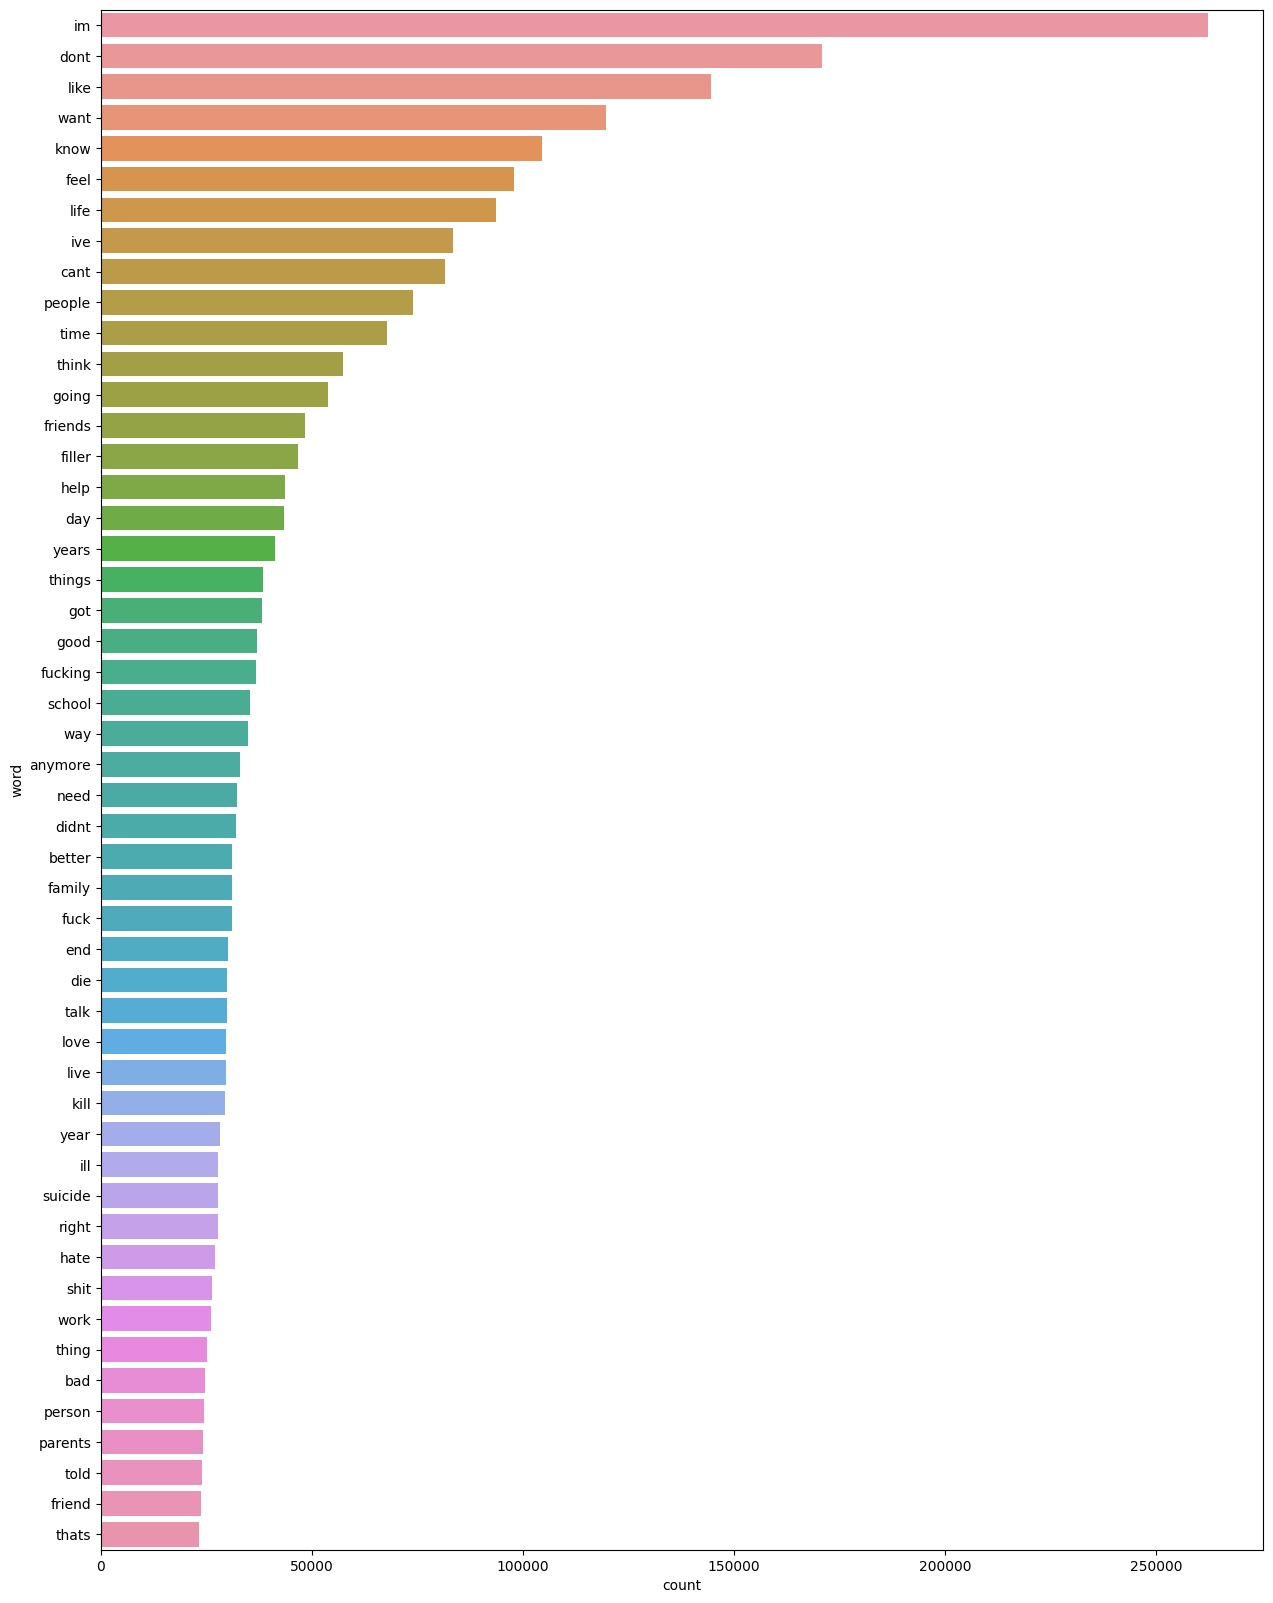

In [32]:
plt.figure(figsize=(15,20))
sns.barplot(x = 'count',y = 'word',data = word_frequency.iloc[:50])
plt.show()

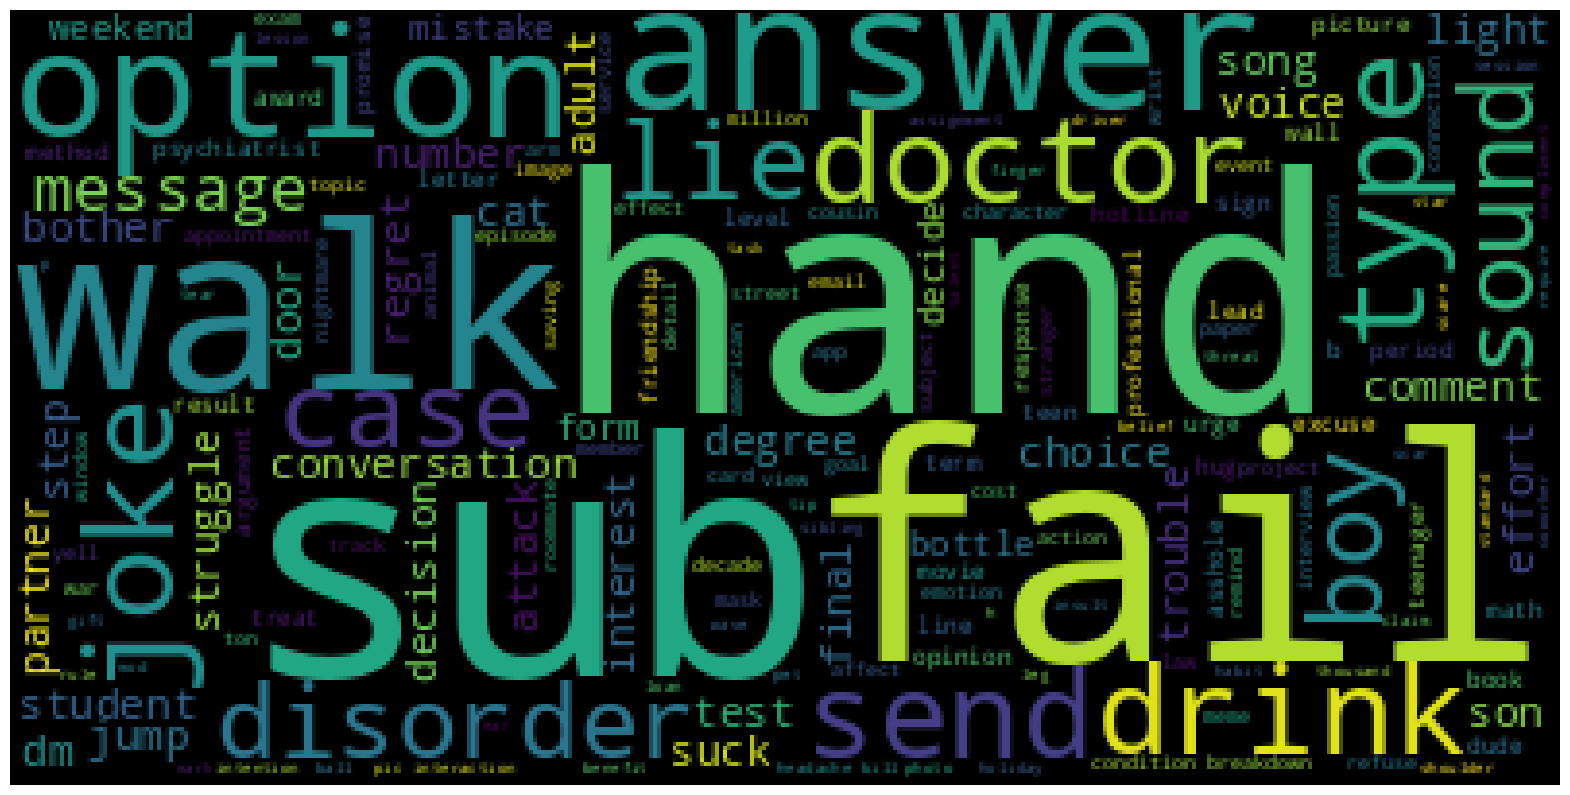

In [33]:
feature_names = word_frequency['word'].values
word_cloud = WordCloud(max_words = 400)
word_cloud.generate(' '.join(word for word in feature_names[500:3500]))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(word_cloud)

In [7]:
train_text_seq=tokenizer.texts_to_sequences(clean_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)


test_text_seq=tokenizer.texts_to_sequences(clean_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [35]:
type(train_text_pad)

numpy.ndarray

In [8]:
label_target=LabelEncoder()
train_output=label_target.fit_transform(train_dataset['class'])
test_output=label_target.transform(test_dataset['class'])

In [37]:
type(train_output)

numpy.ndarray

In [38]:
test_output

array([1, 0, 0, ..., 0, 0, 1])

In [9]:
with open('/home/jvdboss/workspace/ML_DL/Depression-Detection/glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [10]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

---
### Model Building

In [11]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

In [12]:
model=Sequential()
model.add(Input(shape=(50,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
#     model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
#     model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

2023-02-14 14:24:19.837333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 14:24:20.038185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 14:24:20.038670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 14:24:20.054115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [13]:
history=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=256,callbacks=[early_stop,reducelr])

2023-02-14 14:24:48.063761: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37131800 exceeds 10% of free system memory.


Epoch 1/20


2023-02-14 14:25:10.947022: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


726/726 [==============================] - 48s 32ms/step - loss: 0.3537 - accuracy: 0.8487 - val_loss: 0.2553 - val_accuracy: 0.8965 - lr: 0.1000
Epoch 2/20
726/726 [==============================] - 5s 7ms/step - loss: 0.2486 - accuracy: 0.9002 - val_loss: 0.2668 - val_accuracy: 0.8912 - lr: 0.1000
Epoch 3/20
726/726 [==============================] - 6s 8ms/step - loss: 0.2266 - accuracy: 0.9102 - val_loss: 0.2186 - val_accuracy: 0.9140 - lr: 0.1000
Epoch 4/20
726/726 [==============================] - 6s 8ms/step - loss: 0.2077 - accuracy: 0.9185 - val_loss: 0.2088 - val_accuracy: 0.9178 - lr: 0.1000
Epoch 5/20
726/726 [==============================] - 5s 7ms/step - loss: 0.1911 - accuracy: 0.9254 - val_loss: 0.1973 - val_accuracy: 0.9233 - lr: 0.1000
Epoch 6/20
726/726 [==============================] - 5s 6ms/step - loss: 0.1817 - accuracy: 0.9295 - val_loss: 0.1948 - val_accuracy: 0.9244 - lr: 0.1000
Epoch 7/20
726/726 [==============================] - 5s 7ms/step - loss: 0.174

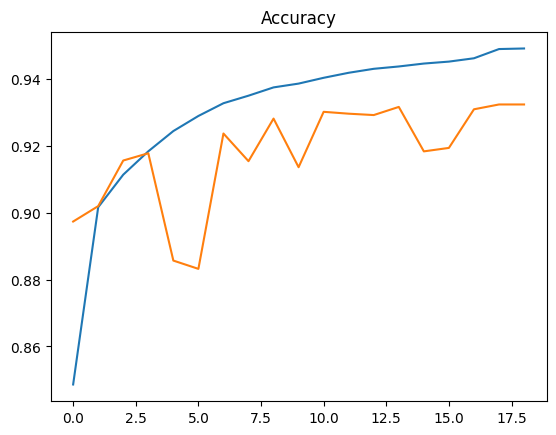

In [15]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.show()

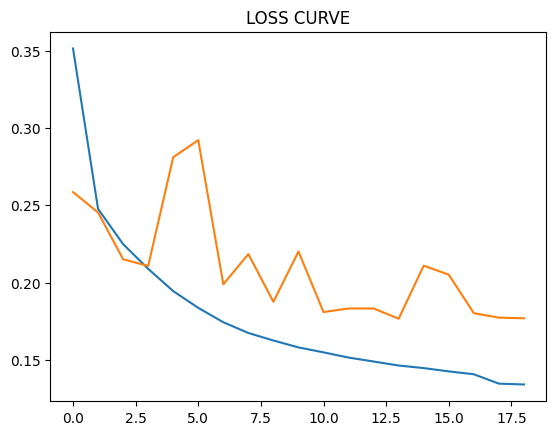

In [16]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LOSS CURVE')
plt.show()

In [14]:
model.evaluate(test_text_pad,test_output)

1451/1451 [==============================] - 3s 2ms/step - loss: 0.1887 - accuracy: 0.9272


[0.18866930902004242, 0.9271787405014038]

In [18]:
prediction = model.predict(test_text_pad)
res = []
for prediction in prediction:
    if prediction[0] < 0.5:
        res.append(0)
    else:
        res.append(1)
# print(confusion_matrix(y_test,res))
# print(res)

1451/1451 [==============================] - 3s 2ms/step


In [23]:
prediction[0]

0.99931765

In [19]:
if prediction > 0.5:
    print("suicidal and depressive")
else:
    print("Not suicidal and not depressive")

suicidal and depressive
